In [1]:
from scipy.io import loadmat
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
import copy

# Import Dataset

In [2]:
with open('../data/02_interim/bmodes_steatosis_assessment_IJCARS.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [3]:
M, N= 434, 636 # ultrasound image dimension

In [28]:
def create_cumul_var_graph(pca):
    ratio = pca.explained_variance_ratio_
    cumulative = np.cumsum(ratio)
    n_components = np.arange(0, len(cumulative))
    plt.plot(n_components, cumulative)
    plt.title("Cumulative Explained Variance by number of components")
    plt.ylabel("Cumulative Ratio")
    plt.xlabel("Number of components")
    

def create_3D_graph(data_3D, classes, ids, fat_pct, filename):
    fig = plt.figure(figsize=(5,15))
    
    #normal vs fatty
    normal = data_3D[classes == 0]
    fatty = data_3D[classes == 1]
    ax1 = fig.add_subplot(311, projection='3d')
    ax1.scatter(normal[:,2], normal[:,1], normal[:,0])
    ax1.scatter(fatty[:,2], fatty[:,1], fatty[:,0])
    ax1.title.set_text("Non Fatty vs Fatty Liver")
    
    #Fat %
    ax2 = fig.add_subplot(312, projection="3d")
    ax2.scatter(data_3D[:,2], data_3D[:,1], data_3D[:,0], c = fat_pct)
    ax2.title.set_text("Coloration by Fat %")
    
    #patient variance
    ax3 = fig.add_subplot(313, projection='3d')
    for i in range(5):
        data_i = data_3D[ids == i]
        ax3.scatter(data_i[:,0], data_i[:,1], data_i[:,2])
        data_i3 = data_3D[ids == i+30]
        ax3.scatter(data_i3[:,0], data_i3[:,1], data_i3[:,2])
    
    ax3.title.set_text("Patients Variance")
    
    plt.savefig(filename + ".png")
        
    return fig

def save_simple_2D_graph(data_2D, classes, ids, filename):
    normal = data_2D[classes == 0]
    fatty = data_2D[classes == 1]
    plt.scatter(normal[:,0], normal[:,1])
    plt.scatter(fatty[:,0], fatty[:,1])
    plt.title("Non Fatty vs Fatty Liver")
    plt.savefig(filename + ".png")

def create_2D_graph(data_2D, classes, ids, fat_pct, filename):
    fig = plt.figure(figsize=(5,15))
    #normal vs fatty
    normal = data_2D[classes == 0]
    fatty = data_2D[classes == 1]
    ax1 = fig.add_subplot(311)
    ax1.scatter(normal[:,0], normal[:,1])
    ax1.scatter(fatty[:,0], fatty[:,1])
    ax1.title.set_text("Non Fatty vs Fatty Liver")
    
    #Fat %
    ax2 = fig.add_subplot(312)
    scatter2 = ax2.scatter(data_2D[:,0], data_2D[:,1], c = fat_pct)
    ax2.title.set_text("Coloration by Fat %")
    plt.colorbar(scatter2,ax=ax2)
    
    #patient variance
    ax3 = fig.add_subplot(313)
    for i in range(5):
        data_i = data_2D[ids == i]
        ax3.scatter(data_i[:,0], data_i[:,1])
        
        data_i3 = data_2D[ids == i+30]
        ax3.scatter(data_i3[:,0], data_i3[:,1])
        
    ax3.title.set_text("Patients Variance")
    
    plt.savefig(filename + ".png")
        
    return fig

## 1. Visualization of Raw US images (No transformation)

In [5]:
# Reshape the data appropriately
data = df['img'].iloc[0].view(1,M*N)
for i in tqdm(range(1,len(df['img']))):
    data = torch.cat([data,df['img'].iloc[i].view(1,M*N)])

100%|████████████████████████████████████████| 549/549 [01:41<00:00,  5.41it/s]


[0.235608   0.30601744 0.34721612 0.37858369 0.40738176 0.43016387
 0.45020239 0.46865764 0.48523594 0.50040584 0.51457536 0.52759443
 0.53980815 0.55134234 0.56191677 0.57210884 0.58175053 0.59106104
 0.60009418 0.60888136 0.61716257 0.62531617 0.63331302 0.64110027
 0.64856104 0.65576257 0.66278081 0.66970402 0.67629611 0.68265339
 0.68896456 0.69515814 0.70109501 0.70695334 0.71278764 0.71838092
 0.7238078  0.72910244 0.73431919 0.73950481 0.74464372 0.74948215
 0.75428352 0.75901026 0.76367938 0.76825429 0.77271593 0.77695174
 0.78113053 0.78515478 0.78909202 0.79286302 0.79646097 0.79986721
 0.80304386 0.80495807 0.80674502 0.80832726 0.80984935 0.81135205
 0.81276701 0.81417699 0.81550492 0.81677184 0.81801961 0.81924335
 0.8204364  0.82160153 0.82275102 0.82389732 0.82503742 0.82615316
 0.82725215 0.82834304 0.82941959 0.83048121 0.83153496 0.83258235
 0.83361404 0.83462727 0.83563168 0.83661634 0.8375948  0.83854648
 0.83948617 0.84041463 0.84133172 0.84223084 0.84312784 0.8440

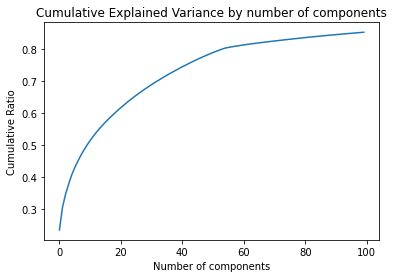

In [6]:
pca = PCA(n_components=100)
pca.fit(data)
pca_data = pca.transform(data)
create_cumul_var_graph(pca)
plt.savefig("PCAcumul-base.png")
print(pca.explained_variance_ratio_.cumsum())

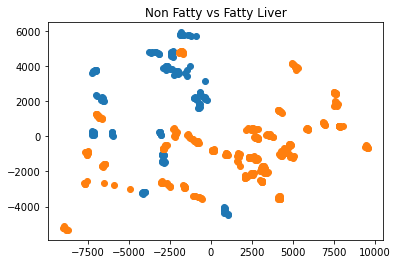

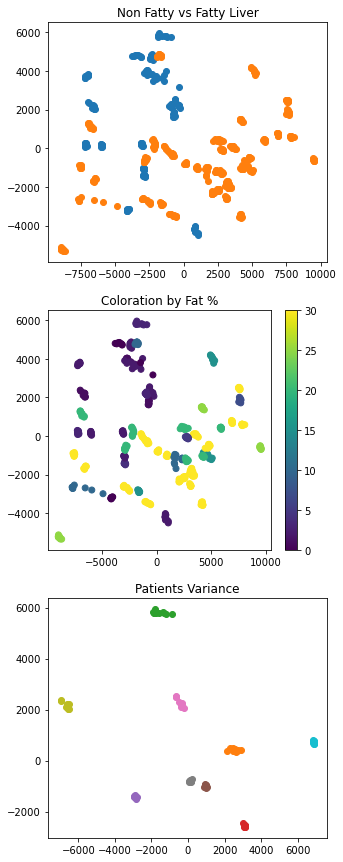

In [7]:
fat_lvl = copy.deepcopy(df['fat'])
fat_lvl[fat_lvl >30] = 30

save_simple_2D_graph(pca_data, df['class'], df['id'], "PCA-base")

fig_2d = create_2D_graph(pca_data, df['class'], df['id'], fat_lvl, "PCA2D-base")

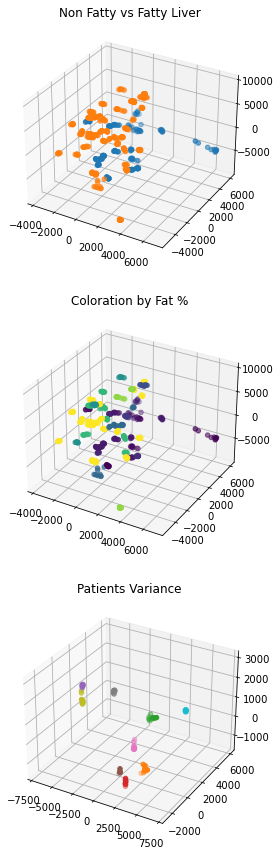

In [29]:
fig_3D = create_3D_graph(pca_data, df['class'], df['id'], fat_lvl, "PCA3D-base")

## 2. Scattering Transform when J=3

In [9]:
# load scattering features when J=2
with open('../data/03_features/scattering_features_J_3.pickle', 'rb') as handle:
    scatter_dict = pickle.load(handle)
    df_scattering = scatter_dict['df']
    scattering_params = {'J':scatter_dict['J'],
                     'M':scatter_dict['M'],
                     'N':scatter_dict['N']}
#Transforming df_scattering to a numpy array excluding class and id
df_scattering.drop("class", inplace = True, axis=1)
df_scattering.drop("id", inplace=True, axis=1)
df_scattering = df_scattering.to_numpy()


In [10]:
#Scattering
pca_s = PCA(n_components=100)
pca_data_s = pca_s.fit_transform(df_scattering)

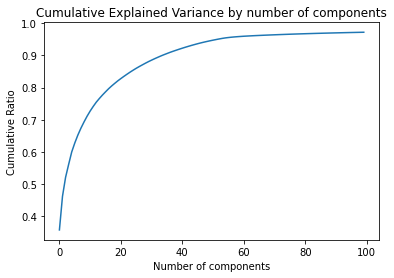

In [11]:
create_cumul_var_graph(pca_s)
plt.savefig("PCAcumul-scattering.png")

In [12]:
print(pca_s.explained_variance_ratio_.cumsum())

[0.35822758 0.4625661  0.52131075 0.5615709  0.6002085  0.6280691
 0.6526925  0.6741057  0.69331694 0.7111806  0.72721285 0.74160945
 0.7549205  0.7662613  0.7769212  0.7868498  0.79648906 0.80517113
 0.8132228  0.8210212  0.8281418  0.835029   0.8416625  0.8480783
 0.85416245 0.86002177 0.8654729  0.87068415 0.8758679  0.8807712
 0.88535535 0.889811   0.8940457  0.8982098  0.90211195 0.9058104
 0.9094688  0.9128608  0.9161207  0.91932636 0.92238843 0.9253971
 0.9282592  0.9310702  0.9337332  0.9363286  0.9387742  0.94106406
 0.9432272  0.9453229  0.94730204 0.94922256 0.9510664  0.95279104
 0.95428663 0.9554627  0.95648295 0.9573706  0.9581335  0.9588018
 0.95944405 0.9599801  0.96049315 0.9609962  0.96147215 0.9619091
 0.96233666 0.96274817 0.9631473  0.9635455  0.96392405 0.9643009
 0.9646717  0.96502525 0.96537423 0.9657152  0.9660432  0.966365
 0.9666778  0.9669834  0.96727717 0.9675648  0.96784616 0.9681226
 0.96838933 0.9686518  0.9689093  0.9691617  0.9694071  0.96965104
 0.969

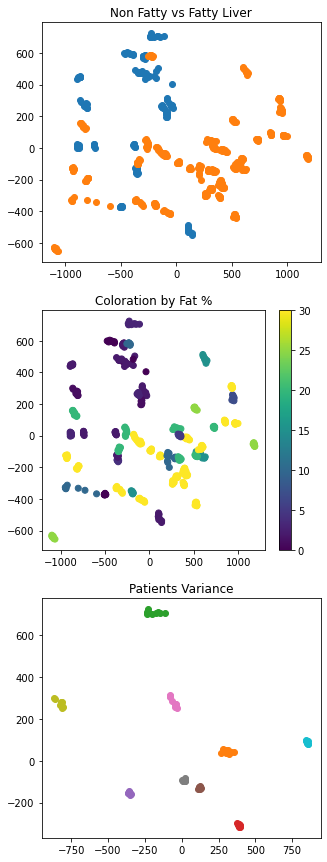

In [13]:
fat_lvl = copy.deepcopy(df['fat'])
fat_lvl[fat_lvl >30] = 30
fig_2d = create_2D_graph(pca_data_s, df['class'], df['id'], fat_lvl, "PCA2D-Scattering")

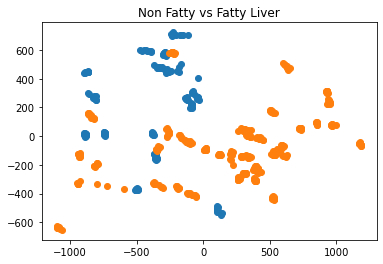

In [16]:
save_simple_2D_graph(pca_data_s, df['class'], df['id'], "PCA-Scattering")

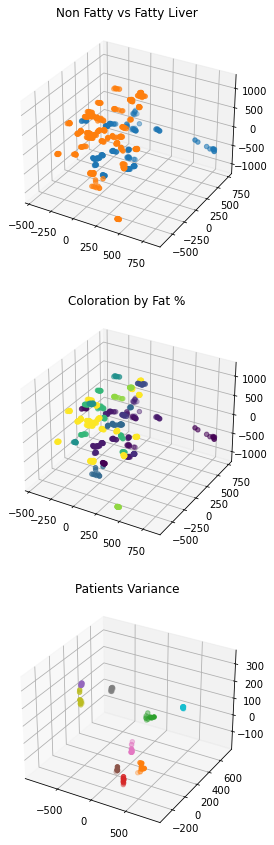

In [30]:
fig_3D = create_3D_graph(pca_data_s, df['class'], df['id'], fat_lvl, "PCA3D-Scattering")

## 3. Scattering Transform when J=2

In [75]:
# load scattering features when J=2
with open('../data/03_features/scattering_features_J_2.pickle', 'rb') as handle:
    scatter_dict = pickle.load(handle)
    df_scattering = scatter_dict['df']
    scattering_params = {'J':scatter_dict['J'],
                     'M':scatter_dict['M'],
                     'N':scatter_dict['N']}


In [76]:
#Transforming df_scattering to a numpy array excluding class and id
df_scattering.drop("class", inplace = True, axis=1)
df_scattering.drop("id", inplace=True, axis=1)
df_scattering = df_scattering.to_numpy()

In [77]:
#Scattering
pca_s = PCA(n_components=100)
pca_s.fit(df_scattering[:,0:100000])
pca_data_s = pca_s.transform(df_scattering[:,0:100000])

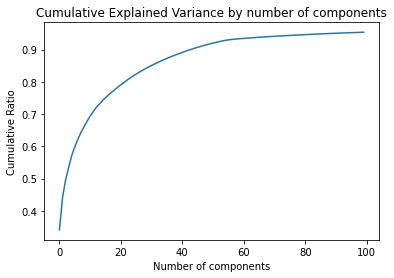

In [78]:
create_cumul_var_graph(pca_s)

In [79]:
print(pca_s.explained_variance_ratio_.cumsum())

[0.34105095 0.44008166 0.495839   0.5346862  0.57157093 0.59840035
 0.62225413 0.64282966 0.66059554 0.6778542  0.69377345 0.7076396
 0.7206258  0.7311401  0.7413698  0.7507628  0.75954235 0.7678417
 0.77584964 0.7835823  0.79087275 0.7980299  0.80516493 0.81179243
 0.81801724 0.82419205 0.8298907  0.83544904 0.84085    0.8459518
 0.85078657 0.8555508  0.8600128  0.8643843  0.86862093 0.8726656
 0.87664384 0.8804263  0.8841062  0.8876131  0.8910812  0.8944839
 0.8977766  0.90095174 0.9040468  0.9070504  0.90979874 0.9124859
 0.915121   0.91757655 0.9199688  0.922234   0.92441887 0.92646897
 0.9283978  0.9298749  0.9311398  0.93206763 0.93290573 0.9336903
 0.93445545 0.93518126 0.9358941  0.93659264 0.9372492  0.9378973
 0.9385366  0.9391666  0.9397783  0.9403821  0.94095916 0.9415234
 0.94208235 0.9426246  0.943155   0.94366837 0.94417936 0.94467854
 0.94516605 0.94565034 0.94612885 0.94660026 0.9470618  0.9475143
 0.9479593  0.9483944  0.9488173  0.9492282  0.94963324 0.95003366
 0.95

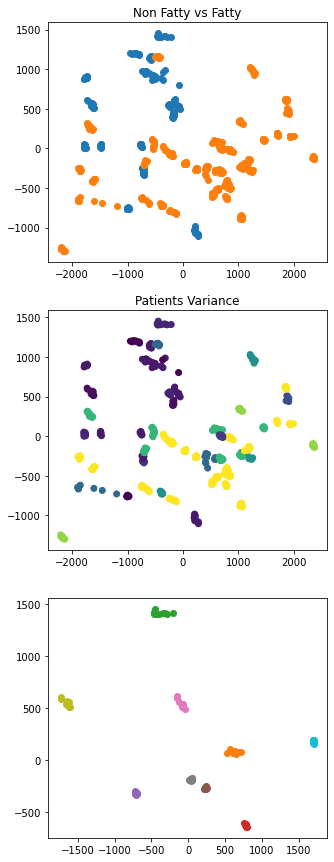

In [135]:
fat_lvl = copy.deepcopy(df['fat'])
fat_lvl[fat_lvl >30] = 30
fig_2d = create_2D_graph(pca_data_s, df['class'], df['id'], fat_lvl)


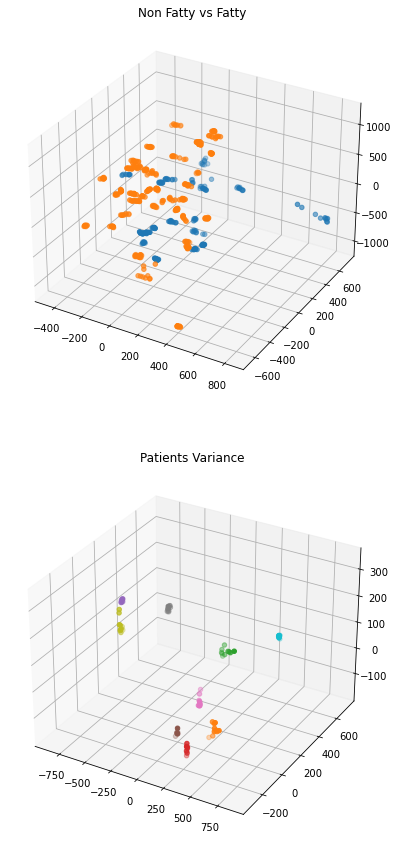

In [152]:
fig_3D = create_3D_graph(pca_data_s, df['class'], df['id'], fat_lvl")

## 4. Deep features

In [19]:
# load scattering features when J=2
with open('../data/03_features/coco.pickle', 'rb') as handle:
    dict_deep_features = pickle.load(handle)
    deep_features = dict_deep_features['features']
    label = dict_deep_features['label']
    pid = dict_deep_features['pid']


In [20]:
deep_features.head()

,id,labels,0,1,2,3,4,5,6,7,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,1,0,0.646589,0.537462,0.401943,0.199506,0.202659,0.294940,0.500032,0.821503,...,0.229985,0.633566,0.206114,0.732518,0.654043,0.275887,0.362820,0.107184,0.501511,0.489348
1,1,0,0.693356,0.374550,0.360310,0.129162,0.239084,0.262954,0.478658,0.791732,...,0.192122,0.485892,0.299204,0.655221,0.580703,0.341523,0.230005,0.092797,0.491484,0.658840
2,1,0,0.693498,0.392269,0.309535,0.125567,0.170291,0.238435,0.447406,0.975266,...,0.134828,0.366664,0.171025,0.465991,0.529727,0.310153,0.244650,0.107581,0.403802,0.578182
3,1,0,0.612398,0.441856,0.305320,0.126919,0.219825,0.259561,0.441000,0.850824,...,0.268535,0.460096,0.280195,0.543408,0.608157,0.337704,0.300175,0.188300,0.455577,0.640827
4,1,0,0.555925,0.398252,0.232700,0.125582,0.220398,0.237641,0.377193,0.840379,...,0.196321,0.381724,0.252318,0.516770,0.624552,0.336688,0.322390,0.077366,0.416017,0.598994


In [21]:
#Transforming df_scattering to a numpy array excluding class and id
label = deep_features.drop("labels", inplace = True, axis=1)
deep_features.drop("id", inplace=True, axis=1)
deep_features = deep_features.to_numpy()

[0.35822758 0.4625661  0.52131075 0.5615709  0.6002085  0.6280691
 0.6526925  0.6741057  0.69331694 0.7111806  0.72721285 0.74160945
 0.7549205  0.7662613  0.7769212  0.7868498  0.79648906 0.80517113
 0.8132228  0.8210212  0.8281418  0.835029   0.8416625  0.8480783
 0.85416245 0.86002177 0.8654729  0.87068415 0.8758679  0.8807712
 0.88535535 0.889811   0.8940457  0.8982098  0.90211195 0.9058104
 0.9094688  0.9128608  0.9161207  0.91932636 0.92238843 0.9253971
 0.9282592  0.9310702  0.9337332  0.9363286  0.9387742  0.94106406
 0.9432272  0.9453229  0.94730204 0.94922256 0.9510664  0.95279104
 0.95428663 0.9554627  0.95648295 0.9573706  0.9581335  0.9588018
 0.95944405 0.9599801  0.96049315 0.9609962  0.96147215 0.9619091
 0.96233666 0.96274817 0.9631473  0.9635455  0.96392405 0.9643009
 0.9646717  0.96502525 0.96537423 0.9657152  0.9660432  0.966365
 0.9666778  0.9669834  0.96727717 0.9675648  0.96784616 0.9681226
 0.96838933 0.9686518  0.9689093  0.9691617  0.9694071  0.96965104
 0.969

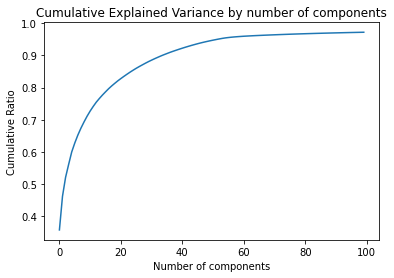

In [22]:
#Scattering
pca_deep = PCA(n_components=100)
pca_deep.fit(deep_features)
pca_data_deep = pca_deep.transform(deep_features)
create_cumul_var_graph(pca_s)
plt.savefig("PCAcumul-deep.png")
print(pca_s.explained_variance_ratio_.cumsum())

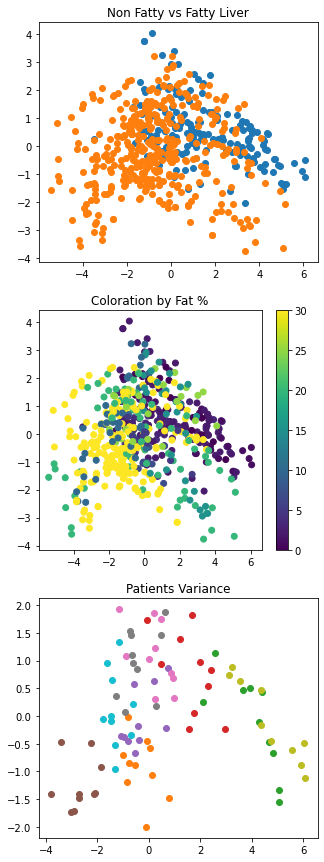

In [34]:
fat_lvl = copy.deepcopy(df['fat'])
fat_lvl[fat_lvl >30] = 30
fig_2d = create_2D_graph(pca_data_deep, df['class'], df['id'], fat_lvl, "PCA2D-DL")

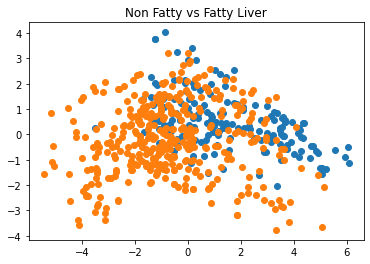

In [35]:
save_simple_2D_graph(pca_data_deep, df['class'], df['id'], "PCA-DL")

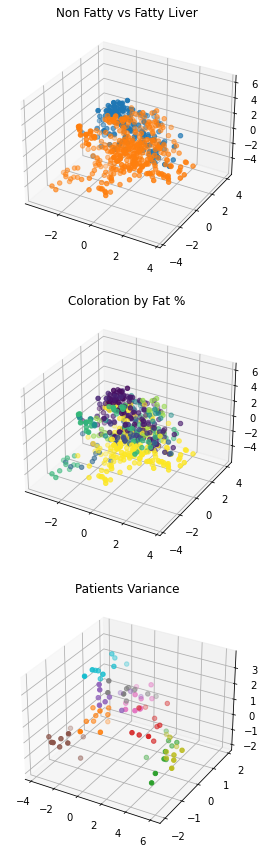

In [33]:
fig_3D = create_3D_graph(pca_data_deep, df['class'], df['id'], fat_lvl, "PCA3D-DL")